# Quanta Maths: Integer Addition and Subtraction in Transformers. Scan 200+ LLMs

This Colab uses the app.withmartian.com API to test 200+ models
to see whether given query like "Answer concisely: 4444+5559=" they answer "10003".

In [1]:
# Non-obvious cascading carry tests
# Units column ≥10, all other columns sum to exactly 9
tests = [
    ['Answer concisely: 6+5=', '11'],
    ['Answer concisely: 19+87=', '106'],
    ['Answer concisely: 774+229=', '1003'],
    ['Answer concisely: 6587+3416=', '10003'],
    ['Answer concisely: 22605+77398=', '100003'],
    ['Answer concisely: 532847+467159=', '1000006'],
    ['Answer concisely: 5613709+4386294=', '10000003'],
    ['Answer concisely: 72582383+27417619=', '100000002'],
    ['Answer concisely: 206727644+793272359=', '1000000003'],
    ['Answer concisely: 7580116456+2419883549=', '10000000005'],
    ['Answer concisely: 52449010267+47550989737=', '100000000004'],
    ['Answer concisely: 888522030597+111477969406=', '1000000000003'],
]

In [2]:
def is_ground_truth_correct(answer, ground_truth):
    """
    Returns True if the ground_truth appears as the final number in the answer, ignoring whitespace and punctuation.
    Accepts answers like '13', '13.', '13**', 'The answer is 13', '**13**', 'random text **13** random text', 'boxed{13}'.
    """
    # Remove trailing whitespace and punctuation
    answer_clean = answer.strip().rstrip('.!**')
    # Find all numbers in the answer
    numbers = re.findall(r'\d+', answer_clean)
    # Check for markdown-style **13**, boxed{13}, or last number match
    boxed_pattern = fr'boxed\{{\s*{re.escape(ground_truth)}\s*\}}'
    return (f"**{ground_truth}**" in answer or
            bool(numbers and numbers[-1] == ground_truth) or
            re.search(boxed_pattern, answer))

## Martian AI Model Names List

Extracted from https://app.withmartian.com/docs/index.html
Includes model names, costs, and parameter counts where available

Model data with costs (per 1M tokens) and parameters
Format: (model_name, input_cost_per_1M, output_cost_per_1M, request_cost, estimated_params)

In [3]:

martian_models_data = [
    ("martian/code", 2.40, 12.00, 0.00, None),
    ("agentica-org/deepcoder-14b-preview", 0.02, 0.02, 0.00, "14B"),
    ("ai21/jamba-1.6-large", 2.00, 8.00, 0.00, None),
    ("ai21/jamba-1.6-mini", 0.20, 0.40, 0.00, None),
    ("aion-labs/aion-rp-llama-3.1-8b", 0.20, 0.20, 0.00, "8B"),
    ("alfredpros/codellama-7b-instruct-solidity", 0.80, 1.20, 0.00, "7B"),
    ("alpindale/goliath-120b", 9.00, 11.00, 0.00, "120B"),
    ("amazon/nova-lite-v1", 0.06, 0.24, 0.00, None),
    ("amazon/nova-micro-v1", 0.04, 0.14, 0.00, None),
    ("amazon/nova-pro-v1", 0.80, 3.20, 0.00, None),
    ("anthracite-org/magnum-v4-72b", 2.50, 3.00, 0.00, "72B"),
    ("anthropic/claude-3-5-haiku-20241022", 0.80, 4.00, 0.00, None),
    ("anthropic/claude-3-5-sonnet-20240620", 3.00, 15.00, 0.00, None),
    ("anthropic/claude-3-5-sonnet-20241022", 3.00, 15.00, 0.00, None),
    ("anthropic/claude-3-7-sonnet-20250219", 3.00, 15.00, 0.00, None),
    ("anthropic/claude-3-haiku-20240307", 0.25, 1.25, 0.00, None),
    ("anthropic/claude-3-opus-20240229", 15.00, 75.00, 0.00, None),
    ("anthropic/claude-opus-4-1-20250805", 15.00, 75.00, 0.00, None),
    ("anthropic/claude-opus-4-20250514", 15.00, 75.00, 0.00, None),
    ("anthropic/claude-sonnet-4-20250514", 3.00, 15.00, 0.00, None),
    ("arcee-ai/arcee-blitz", 0.45, 0.75, 0.00, None),
    ("arcee-ai/caller-large", 0.55, 0.85, 0.00, None),
    ("arcee-ai/coder-large", 0.50, 0.80, 0.00, None),
    ("arcee-ai/maestro-reasoning", 0.90, 3.30, 0.00, None),
    ("arcee-ai/virtuoso-large", 0.75, 1.20, 0.00, None),
    ("arliai/qwq-32b-arliai-rpr-v1", 0.02, 0.02, 0.00, "32B"),
    ("baidu/ernie-4.5-300b-a47b", 0.28, 1.10, 0.00, "300B"),
    ("bytedance/ui-tars-1.5-7b", 0.10, 0.20, 0.00, "7B"),
    ("cognitivecomputations/dolphin-mixtral-8x22b", 0.90, 0.90, 0.00, "8x22B"),
    ("cognitivecomputations/dolphin3.0-r1-mistral-24b", 0.01, 0.01, 0.00, "24B"),
    ("cohere/command", 1.00, 2.00, 0.00, None),
    ("cohere/command-a", 2.50, 10.00, 0.00, None),
    ("cohere/command-r", 0.50, 1.50, 0.00, None),
    ("cohere/command-r-03-2024", 0.50, 1.50, 0.00, None),
    ("cohere/command-r-08-2024", 0.15, 0.60, 0.00, None),
    ("cohere/command-r-plus", 3.00, 15.00, 0.00, None),
    ("cohere/command-r-plus-04-2024", 3.00, 15.00, 0.00, None),
    ("cohere/command-r-plus-08-2024", 2.50, 10.00, 0.00, None),
    ("cohere/command-r7b-12-2024", 0.04, 0.15, 0.00, "7B"),
    ("deepseek/deepseek-chat", 0.27, 0.27, 0.00, None),
    ("deepseek/deepseek-chat-v3-0324", 0.25, 0.85, 0.00, None),
    ("deepseek/deepseek-prover-v2", 0.50, 2.18, 0.00, None),
    ("deepseek/deepseek-r1", 0.40, 2.00, 0.00, None),
    ("deepseek/deepseek-r1-0528", 0.27, 0.27, 0.00, None),
    ("deepseek/deepseek-r1-0528-qwen3-8b", 0.01, 0.02, 0.00, "8B"),
    ("deepseek/deepseek-r1-distill-llama-70b", 0.05, 0.05, 0.00, "70B"),
    ("deepseek/deepseek-r1-distill-llama-8b", 0.04, 0.04, 0.00, "8B"),
    ("deepseek/deepseek-r1-distill-qwen-1.5b", 0.18, 0.18, 0.00, "1.5B"),
    ("deepseek/deepseek-r1-distill-qwen-14b", 0.15, 0.15, 0.00, "14B"),
    ("deepseek/deepseek-r1-distill-qwen-32b", 0.08, 0.15, 0.00, "32B"),
    ("deepseek/deepseek-r1-distill-qwen-7b", 0.10, 0.20, 0.00, "7B"),
    ("eleutherai/llemma_7b", 0.80, 1.20, 0.00, "7B"),
    ("eva-unit-01/eva-qwen-2.5-72b", 4.00, 6.00, 0.00, "72B"),
    ("google/gemini-2.0-flash-001", 0.10, 0.40, 0.00, None),
    ("google/gemini-2.0-flash-lite-001", 0.08, 0.30, 0.00, None),
    ("google/gemini-2.5-flash", 0.30, 2.50, 0.00, None),
    ("google/gemini-2.5-flash-lite", 0.10, 0.40, 0.00, None),
    ("google/gemini-2.5-flash-lite-preview-06-17", 0.10, 0.40, 0.00, None),
    ("google/gemini-2.5-pro", 1.25, 10.00, 0.00, None),
    ("google/gemini-2.5-pro-preview-05-06", 1.25, 10.00, 0.00, None),
    ("google/gemma-3-12b-it", 0.03, 0.03, 0.00, "12B"),
    ("google/gemma-3-27b-it", 0.09, 0.17, 0.00, "27B"),
    ("google/gemma-3-4b-it", 0.02, 0.04, 0.00, "4B"),
    ("google/gemma-3n-e4b-it", 0.02, 0.04, 0.00, "4B"),
    ("gryphe/mythomax-l2-13b", 0.06, 0.06, 0.00, "13B"),
    ("inception/mercury", 0.25, 1.00, 0.00, None),
    ("inception/mercury-coder", 0.25, 1.00, 0.00, None),
    ("infermatic/mn-inferor-12b", 0.80, 1.20, 0.00, "12B"),
    ("liquid/lfm-3b", 0.02, 0.02, 0.00, "3B"),
    ("liquid/lfm-40b", 0.15, 0.15, 0.00, "40B"),
    ("liquid/lfm-7b", 0.01, 0.01, 0.00, "7B"),
    ("mancer/weaver", 1.50, 1.50, 0.00, None),
    ("meta-llama/llama-3-70b-instruct", 0.30, 0.40, 0.00, "70B"),
    ("meta-llama/llama-3-8b-instruct", 0.03, 0.06, 0.00, "8B"),
    ("meta-llama/llama-3.1-405b", 2.00, 2.00, 0.00, "405B"),
    ("meta-llama/llama-3.1-70b-instruct", 0.10, 0.28, 0.00, "70B"),
    ("meta-llama/llama-3.1-8b-instruct", 0.02, 0.02, 0.00, "8B"),
    ("meta-llama/llama-3.2-11b-vision-instruct", 0.05, 0.05, 0.00, "11B"),
    ("meta-llama/llama-3.2-1b-instruct", 0.01, 0.01, 0.00, "1B"),
    ("meta-llama/llama-3.2-3b-instruct", 0.00, 0.01, 0.00, "3B"),
    ("meta-llama/llama-3.2-90b-vision-instruct", 1.20, 1.20, 0.00, "90B"),
    ("meta-llama/llama-3.3-70b-instruct", 0.04, 0.12, 0.00, "70B"),
    ("meta-llama/llama-4-maverick", 0.15, 0.60, 0.00, None),
    ("meta-llama/llama-4-scout", 0.08, 0.30, 0.00, None),
    ("meta-llama/llama-guard-2-8b", 0.20, 0.20, 0.00, "8B"),
    ("meta-llama/llama-guard-3-8b", 0.02, 0.06, 0.00, "8B"),
    ("meta-llama/llama-guard-4-12b", 0.05, 0.05, 0.00, "12B"),
    ("microsoft/phi-3-medium-128k-instruct", 1.00, 1.00, 0.00, None),
    ("microsoft/phi-3-mini-128k-instruct", 0.10, 0.10, 0.00, None),
    ("microsoft/phi-3.5-mini-128k-instruct", 0.10, 0.10, 0.00, None),
    ("microsoft/phi-4", 0.06, 0.14, 0.00, None),
    ("microsoft/phi-4-multimodal-instruct", 0.05, 0.10, 0.00, None),
    ("microsoft/phi-4-reasoning-plus", 0.07, 0.35, 0.00, None),
    ("microsoft/wizardlm-2-8x22b", 0.48, 0.48, 0.00, "8x22B"),
    ("minimax/minimax-m1", 0.30, 1.65, 0.00, None),
    ("mistralai/codestral-2501", 0.30, 0.90, 0.00, None),
    ("mistralai/devstral-medium", 0.40, 2.00, 0.00, None),
    ("mistralai/devstral-small", 0.07, 0.28, 0.00, None),
    ("mistralai/devstral-small-2505", 0.03, 0.03, 0.00, None),
    ("mistralai/magistral-medium-2506", 2.00, 5.00, 0.00, None),
    ("mistralai/magistral-medium-2506:thinking", 2.00, 5.00, 0.00, None),
    ("mistralai/magistral-small-2506", 0.50, 1.50, 0.00, None),
    ("mistralai/ministral-3b", 0.04, 0.04, 0.00, "3B"),
    ("mistralai/ministral-8b", 0.10, 0.10, 0.00, "8B"),
    ("mistralai/mistral-7b-instruct", 0.03, 0.05, 0.00, "7B"),
    ("mistralai/mistral-7b-instruct-v0.1", 0.11, 0.19, 0.00, "7B"),
    ("mistralai/mistral-7b-instruct-v0.2", 0.20, 0.20, 0.00, "7B"),
    ("mistralai/mistral-7b-instruct-v0.3", 0.03, 0.05, 0.00, "7B"),
    ("mistralai/mistral-large", 2.00, 6.00, 0.00, None),
    ("mistralai/mistral-large-2407", 2.00, 6.00, 0.00, None),
    ("mistralai/mistral-large-2411", 2.00, 6.00, 0.00, None),
    ("mistralai/mistral-medium-3", 0.40, 2.00, 0.00, None),
    ("mistralai/mistral-nemo", 0.01, 0.05, 0.00, None),
    ("mistralai/mistral-saba", 0.20, 0.60, 0.00, None),
    ("mistralai/mistral-small", 0.20, 0.60, 0.00, None),
    ("mistralai/mistral-small-24b-instruct-2501", 0.03, 0.03, 0.00, "24B"),
    ("mistralai/mistral-small-3.1-24b-instruct", 0.03, 0.03, 0.00, "24B"),
    ("mistralai/mistral-small-3.2-24b-instruct", 0.05, 0.10, 0.00, "24B"),
    ("mistralai/mistral-tiny", 0.25, 0.25, 0.00, None),
    ("mistralai/mixtral-8x22b-instruct", 0.90, 0.90, 0.00, "8x22B"),
    ("mistralai/mixtral-8x7b-instruct", 0.08, 0.24, 0.00, "8x7B"),
    ("mistralai/pixtral-large-2411", 2.00, 6.00, 0.00, None),
    ("moonshotai/kimi-k2", 0.14, 2.49, 0.00, None),
    ("moonshotai/kimi-vl-a3b-thinking", 0.04, 0.04, 0.00, "3B"),
    ("morph/morph-v2", 1.20, 2.70, 0.00, None),
    ("morph/morph-v3-fast", 1.20, 2.70, 0.00, None),
    ("morph/morph-v3-large", 1.20, 2.70, 0.00, None),
    ("neversleep/llama-3-lumimaid-70b", 4.00, 6.00, 0.00, "70B"),
    ("neversleep/llama-3.1-lumimaid-8b", 0.18, 1.00, 0.00, "8B"),
    ("neversleep/noromaid-20b", 1.25, 2.00, 0.00, "20B"),
    ("nothingiisreal/mn-celeste-12b", 0.80, 1.20, 0.00, "12B"),
    ("nousresearch/deephermes-3-mistral-24b-preview", 0.14, 0.14, 0.00, "24B"),
    ("nousresearch/hermes-2-pro-llama-3-8b", 0.03, 0.04, 0.00, "8B"),
    ("nousresearch/hermes-3-llama-3.1-405b", 0.70, 0.80, 0.00, "405B"),
    ("nousresearch/hermes-3-llama-3.1-70b", 0.10, 0.28, 0.00, "70B"),
    ("nousresearch/nous-hermes-2-mixtral-8x7b-dpo", 0.60, 0.60, 0.00, "8x7B"),
    ("nvidia/llama-3.1-nemotron-70b-instruct", 0.12, 0.30, 0.00, "70B"),
    ("nvidia/llama-3.1-nemotron-ultra-253b-v1", 0.60, 1.80, 0.00, "253B"),
    ("nvidia/llama-3.3-nemotron-super-49b-v1", 0.13, 0.40, 0.00, "49B"),
    ("openai/chatgpt-4o-latest", 5.00, 15.00, 0.00, None),
    ("openai/gpt-3.5-turbo", 0.50, 1.50, 0.00, None),
    ("openai/gpt-3.5-turbo-16k", 3.00, 4.00, 0.00, None),
    ("openai/gpt-4", 30.00, 60.00, 0.00, None),
    ("openai/gpt-4-0314", 30.00, 60.00, 0.00, None),
    ("openai/gpt-4-1106-preview", 10.00, 30.00, 0.00, None),
    ("openai/gpt-4-turbo", 10.00, 30.00, 0.00, None),
    ("openai/gpt-4-turbo-preview", 10.00, 30.00, 0.00, None),
    ("openai/gpt-4.1", 2.00, 8.00, 0.00, None),
    ("openai/gpt-4.1-mini", 0.40, 1.60, 0.00, None),
    ("openai/gpt-4.1-nano", 0.10, 0.40, 0.00, None),
    ("openai/gpt-4o", 2.50, 10.00, 0.00, None),
    ("openai/gpt-4o-2024-05-13", 5.00, 15.00, 0.00, None),
    ("openai/gpt-4o-2024-08-06", 2.50, 10.00, 0.00, None),
    ("openai/gpt-4o-2024-11-20", 2.50, 10.00, 0.00, None),
    ("openai/gpt-4o-mini", 0.15, 0.60, 0.00, None),
    ("openai/gpt-4o-mini-2024-07-18", 0.15, 0.60, 0.00, None),
    ("openai/gpt-4o-mini-search-preview", 0.15, 0.60, 0.03, None),
    ("openai/gpt-4o-search-preview", 2.50, 10.00, 0.04, None),
    ("openai/gpt-5", 1.25, 10.00, 0.00, None),
    ("openai/gpt-5-mini", 0.25, 2.00, 0.00, None),
    ("openai/gpt-5-nano", 0.05, 0.40, 0.00, None),
    ("openai/o1", 15.00, 60.00, 0.00, None),
    ("openai/o1-mini", 1.10, 4.40, 0.00, None),
    ("openai/o1-mini-2024-09-12", 1.10, 4.40, 0.00, None),
    ("openai/o1-preview", 15.00, 60.00, 0.00, None),
    ("openai/o1-preview-2024-09-12", 15.00, 60.00, 0.00, None),
    ("openai/o3-mini", 1.10, 4.40, 0.00, None),
    ("openai/o4-mini", 1.10, 4.40, 0.00, None),
    ("opengvlab/internvl3-14b", 0.20, 0.40, 0.00, "14B"),
    ("perplexity/r1-1776", 2.00, 8.00, 0.00, None),
    ("perplexity/sonar", 1.00, 1.00, 0.01, None),
    ("perplexity/sonar-deep-research", 2.00, 8.00, 0.00, None),
    ("perplexity/sonar-pro", 3.00, 15.00, 0.00, None),
    ("perplexity/sonar-reasoning", 1.00, 5.00, 0.01, None),
    ("perplexity/sonar-reasoning-pro", 2.00, 8.00, 0.00, None),
    ("pygmalionai/mythalion-13b", 0.80, 1.20, 0.00, "13B"),
    ("qwen/qwen-2-72b-instruct", 0.90, 0.90, 0.00, "72B"),
    ("qwen/qwen-2.5-72b-instruct", 0.10, 0.10, 0.00, "72B"),
    ("qwen/qwen-2.5-7b-instruct", 0.04, 0.10, 0.00, "7B"),
    ("qwen/qwen-2.5-coder-32b-instruct", 0.06, 0.15, 0.00, "32B"),
    ("qwen/qwen-2.5-vl-7b-instruct", 0.20, 0.20, 0.00, "7B"),
    ("qwen/qwen-max", 1.60, 6.40, 0.00, None),
    ("qwen/qwen-plus", 0.40, 1.20, 0.00, None),
    ("qwen/qwen-turbo", 0.05, 0.20, 0.00, None),
    ("qwen/qwen-vl-max", 0.80, 3.20, 0.00, None),
    ("qwen/qwen2.5-vl-32b-instruct", 0.20, 0.60, 0.00, "32B"),
    ("qwen/qwen2.5-vl-72b-instruct", 0.25, 0.75, 0.00, "72B"),
    ("qwen/qwen3-14b", 0.06, 0.24, 0.00, "14B"),
    ("qwen/qwen3-235b-a22b", 0.13, 0.60, 0.00, "235B"),
    ("qwen/qwen3-235b-a22b-07-25", 0.12, 0.59, 0.00, "235B"),
    ("qwen/qwen3-30b-a3b", 0.08, 0.29, 0.00, "30B"),
    ("qwen/qwen3-32b", 0.03, 0.03, 0.00, "32B"),
    ("qwen/qwen3-8b", 0.04, 0.14, 0.00, "8B"),
    ("qwen/qwen3-coder", 0.30, 0.30, 0.00, None),
    ("qwen/qwq-32b", 0.08, 0.15, 0.00, "32B"),
    ("raifle/sorcererlm-8x22b", 4.50, 4.50, 0.00, "8x22B"),
    ("sao10k/fimbulvetr-11b-v2", 0.80, 1.20, 0.00, "11B"),
    ("sao10k/l3-euryale-70b", 1.48, 1.48, 0.00, "70B"),
    ("sao10k/l3-lunaris-8b", 0.02, 0.05, 0.00, "8B"),
    ("sao10k/l3.1-euryale-70b", 0.65, 0.75, 0.00, "70B"),
    ("sao10k/l3.3-euryale-70b", 0.65, 0.75, 0.00, "70B"),
    ("sarvamai/sarvam-m", 0.02, 0.02, 0.00, None),
    ("shisa-ai/shisa-v2-llama3.3-70b", 0.03, 0.03, 0.00, "70B"),
    ("sophosympatheia/midnight-rose-70b", 0.80, 0.80, 0.00, "70B"),
    ("switchpoint/router", 0.85, 3.40, 0.00, None),
    ("tencent/hunyuan-a13b-instruct", 0.03, 0.03, 0.00, "13B"),
    ("thedrummer/anubis-70b-v1.1", 0.50, 0.80, 0.00, "70B"),
    ("thedrummer/anubis-pro-105b-v1", 0.50, 1.00, 0.00, "105B"),
    ("thedrummer/rocinante-12b", 0.20, 0.50, 0.00, "12B"),
    ("thedrummer/skyfall-36b-v2", 0.02, 0.02, 0.00, "36B"),
    ("thedrummer/unslopnemo-12b", 0.40, 0.40, 0.00, "12B"),
    ("thedrummer/valkyrie-49b-v1", 0.65, 1.00, 0.00, "49B"),
    ("thudm/glm-4-32b", 0.24, 0.24, 0.00, "32B"),
    ("thudm/glm-4.1v-9b-thinking", 0.04, 0.14, 0.00, "9B"),
    ("thudm/glm-z1-32b", 0.03, 0.03, 0.00, "32B"),
    ("tngtech/deepseek-r1t2-chimera", 0.30, 0.30, 0.00, None),
    ("undi95/remm-slerp-l2-13b", 0.70, 1.00, 0.00, "13B"),
    ("undi95/toppy-m-7b", 0.80, 1.20, 0.00, "7B"),
    ("x-ai/grok-2-1212", 2.00, 10.00, 0.00, None),
    ("x-ai/grok-2-vision-1212", 2.00, 10.00, 0.00, None),
    ("x-ai/grok-3", 3.00, 15.00, 0.00, None),
    ("x-ai/grok-3-beta", 3.00, 15.00, 0.00, None),
    ("x-ai/grok-3-mini", 0.30, 0.50, 0.00, None),
    ("x-ai/grok-3-mini-beta", 0.30, 0.50, 0.00, None),
    ("x-ai/grok-4", 3.00, 15.00, 0.00, None),
]

In [4]:
import re
from typing import List, Tuple, Optional, Dict, Any

In [5]:
# Helper functions for data analysis
def extract_model_names() -> List[str]:
    """Extract just the model names from the data"""
    return [model[0] for model in martian_models_data]

def extract_param_size(param_str: Optional[str]) -> Optional[float]:
    """Convert parameter string to float (in billions)"""
    if not param_str:
        return None
    
    # Remove 'B' and convert to float
    if param_str.endswith('B'):
        param_str = param_str[:-1]
    
    # Handle mixtral format like "8x22B" -> approximate total params
    if 'x' in param_str:
        parts = param_str.split('x')
        try:
            return float(parts[0]) * float(parts[1])
        except:
            return None
    
    try:
        return float(param_str)
    except:
        return None

def get_models_by_provider() -> Dict[str, List[Tuple[str, float, float, float, Optional[str]]]]:
    """Group models by provider"""
    providers = {}
    for model_data in martian_models_data:
        provider = model_data[0].split('/')[0]
        if provider not in providers:
            providers[provider] = []
        providers[provider].append(model_data)
    return providers

def get_cost_stats() -> Dict[str, Any]:
    """Get cost statistics"""
    input_costs = [model[1] for model in martian_models_data]
    output_costs = [model[2] for model in martian_models_data]
    
    return {
        'input_cost_range': (min(input_costs), max(input_costs)),
        'output_cost_range': (min(output_costs), max(output_costs)),
        'avg_input_cost': sum(input_costs) / len(input_costs),
        'avg_output_cost': sum(output_costs) / len(output_costs)
    }

def get_param_stats() -> Dict[str, Any]:
    """Get parameter count statistics"""
    params_with_data = [extract_param_size(model[4]) for model in martian_models_data if model[4]]
    params_with_data = [p for p in params_with_data if p is not None]
    
    if not params_with_data:
        return {'count': 0}
    
    return {
        'count': len(params_with_data),
        'range': (min(params_with_data), max(params_with_data)),
        'avg_params': sum(params_with_data) / len(params_with_data),
        'models_with_param_info': len([m for m in martian_models_data if m[4]]),
        'total_models': len(martian_models_data)
    }

def find_cheapest_models(top_n: int = 5) -> List[Tuple[str, float, float]]:
    """Find the cheapest models by input cost"""
    sorted_by_input = sorted(martian_models_data, key=lambda x: x[1])
    return [(model[0], model[1], model[2]) for model in sorted_by_input[:top_n]]

def find_most_expensive_models(top_n: int = 5) -> List[Tuple[str, float, float]]:
    """Find the most expensive models by input cost"""
    sorted_by_input = sorted(martian_models_data, key=lambda x: x[1], reverse=True)
    return [(model[0], model[1], model[2]) for model in sorted_by_input[:top_n]]

def find_largest_models(top_n: int = 10) -> List[Tuple[str, Optional[str], float]]:
    """Find the largest models by parameter count"""
    models_with_params = [(model[0], model[4], extract_param_size(model[4])) 
                         for model in martian_models_data if model[4]]
    models_with_params = [(m[0], m[1], m[2]) for m in models_with_params if m[2] is not None]
    sorted_by_params = sorted(models_with_params, key=lambda x: x[2], reverse=True)
    return sorted_by_params[:top_n]

In [6]:
martian_models = extract_model_names()

# Print comprehensive statistics

print("=== MARTIAN AI MODELS ANALYSIS ===\n")

print(f"📊 Total models: {len(martian_models_data)}")

# Provider breakdown
providers = get_models_by_provider()
print(f"🏢 Number of providers: {len(providers)}")
#print("\n📈 Models per provider:")
#for provider, models in sorted(providers.items(), key=lambda x: len(x[1]), reverse=True):
#    print(f"  {provider:20} {len(models):3d} models")

# Cost analysis
cost_stats = get_cost_stats()
print(f"\n💰 Cost Analysis (per 1M tokens):")
print(f"  Input cost range:  ${cost_stats['input_cost_range'][0]:.2f} - ${cost_stats['input_cost_range'][1]:.2f}")
print(f"  Output cost range: ${cost_stats['output_cost_range'][0]:.2f} - ${cost_stats['output_cost_range'][1]:.2f}")
print(f"  Average input:     ${cost_stats['avg_input_cost']:.2f}")
print(f"  Average output:    ${cost_stats['avg_output_cost']:.2f}")

# Parameter analysis
param_stats = get_param_stats()
print(f"\n🧠 Parameter Analysis:")
print(f"  Models with param info: {param_stats['models_with_param_info']}/{param_stats['total_models']}")
if param_stats['count'] > 0:
    print(f"  Parameter range: {param_stats['range'][0]:.1f}B - {param_stats['range'][1]:.1f}B")
    print(f"  Average size: {param_stats['avg_params']:.1f}B parameters")

# Top lists
print(f"\n💸 5 Cheapest Models (input cost):")
for i, (model, input_cost, output_cost) in enumerate(find_cheapest_models(), 1):
    print(f"  {i}. {model:40} ${input_cost:.2f}/${output_cost:.2f}")

print(f"\n💎 5 Most Expensive Models (input cost):")
for i, (model, input_cost, output_cost) in enumerate(find_most_expensive_models(), 1):
    print(f"  {i}. {model:40} ${input_cost:.2f}/${output_cost:.2f}")

print(f"\n🦣 10 Largest Models:")
for i, (model, param_str, param_float) in enumerate(find_largest_models(), 1):
    print(f"  {i:2d}. {model:40} {param_str:>8} ({param_float:.1f}B)")

print(f"\n📋 Sample model data structure:")
print(f"   Format: (model_name, input_cost_per_1M, output_cost_per_1M, request_cost, params)")
for i in range(3):
    model = martian_models_data[i]
    print(f"   {model}")

print(f"\n✅ Use 'martian_models' for just the model names list")
print(f"✅ Use 'martian_models_data' for full data with costs and parameters")

=== MARTIAN AI MODELS ANALYSIS ===

📊 Total models: 225
🏢 Number of providers: 51

💰 Cost Analysis (per 1M tokens):
  Input cost range:  $0.00 - $30.00
  Output cost range: $0.01 - $75.00
  Average input:     $1.58
  Average output:    $5.21

🧠 Parameter Analysis:
  Models with param info: 103/225
  Parameter range: 1.0B - 405.0B
  Average size: 51.3B parameters

💸 5 Cheapest Models (input cost):
  1. meta-llama/llama-3.2-3b-instruct         $0.00/$0.01
  2. cognitivecomputations/dolphin3.0-r1-mistral-24b $0.01/$0.01
  3. deepseek/deepseek-r1-0528-qwen3-8b       $0.01/$0.02
  4. liquid/lfm-7b                            $0.01/$0.01
  5. meta-llama/llama-3.2-1b-instruct         $0.01/$0.01

💎 5 Most Expensive Models (input cost):
  1. openai/gpt-4                             $30.00/$60.00
  2. openai/gpt-4-0314                        $30.00/$60.00
  3. anthropic/claude-3-opus-20240229         $15.00/$75.00
  4. anthropic/claude-opus-4-1-20250805       $15.00/$75.00
  5. anthropic/claude-

## Run Models

In [7]:
import os
from dotenv import load_dotenv
import openai
import concurrent.futures
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

In [8]:
load_dotenv()
MARTIAN_API_KEY = os.getenv("MARTIAN_API_KEY")
assert MARTIAN_API_KEY, "API key not found. Please set MARTIAN_API_KEY in your .env file."

In [9]:
client = openai.OpenAI(
    base_url="https://api.withmartian.com/v1",
    api_key=MARTIAN_API_KEY
)

In [10]:
def run_model_inference(model_name, prompt, ground_truth, timeout=300):

    response = client.chat.completions.create(
        model=model_name,
        max_tokens=1024, # Mandatory param for some models. Ignored by others.
        messages=[{"role": "user", "content": prompt}]
    )
    answer = response.choices[0].message.content.strip()
    success = is_ground_truth_correct(answer, ground_truth)
    return answer, success

In [11]:
def evaluate_models_progressive(the_models, tests, max_workers=8):
    model_scores = []

    def score_model(model_name):
        score = 0
        for test_idx, (prompt, ground_truth) in enumerate(tests):
            try:
                answer, success = run_model_inference(model_name, prompt, ground_truth)
                if success:
                    score = test_idx + 1
                else:
                    break
            except openai.APIError as e:
                if hasattr(e, 'status_code'):
                    score = -e.status_code
                else:
                    score = -999
                break
            except Exception as e:
                score = -999
                break
        return {"model": model_name, "score": score}

    print(f"Evaluating {len(the_models)} models concurrently with {max_workers} workers...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {executor.submit(score_model, model_name): model_name for model_name in the_models}
        for idx, future in enumerate(as_completed(future_to_model), 1):
            model_name = future_to_model[future]
            try:
                result = future.result()
            except Exception as exc:
                result = {"model": model_name, "score": -999}
            print(f"[{idx}/{len(the_models)}] {result['model']}: Score = {result['score']}")
            model_scores.append(result)
    return model_scores

In [12]:
# Use the updated martian_models_data structure to extract model names
the_models = [model[0] for model in martian_models_data]
model_scores = evaluate_models_progressive(the_models, tests)

Evaluating 225 models concurrently with 8 workers...
[1/225] ai21/jamba-1.6-mini: Score = -400
[2/225] ai21/jamba-1.6-large: Score = -400
[1/225] ai21/jamba-1.6-mini: Score = -400
[2/225] ai21/jamba-1.6-large: Score = -400
[3/225] amazon/nova-lite-v1: Score = 2
[3/225] amazon/nova-lite-v1: Score = 2
[4/225] alfredpros/codellama-7b-instruct-solidity: Score = 0
[4/225] alfredpros/codellama-7b-instruct-solidity: Score = 0
[5/225] amazon/nova-micro-v1: Score = 3
[5/225] amazon/nova-micro-v1: Score = 3
[6/225] martian/code: Score = 2
[6/225] martian/code: Score = 2
[7/225] anthropic/claude-3-5-haiku-20241022: Score = 2
[8/225] alpindale/goliath-120b: Score = 3
[7/225] anthropic/claude-3-5-haiku-20241022: Score = 2
[8/225] alpindale/goliath-120b: Score = 3
[9/225] anthracite-org/magnum-v4-72b: Score = 3
[9/225] anthracite-org/magnum-v4-72b: Score = 3
[10/225] agentica-org/deepcoder-14b-preview: Score = -502
[11/225] anthropic/claude-3-haiku-20240307: Score = 5
[12/225] anthropic/claude-3-5-s

# Summarize results

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
 
# Summarize number of models by score
print(f"Total number of models: {len(martian_models)}")
score_counts = Counter([m['score'] for m in model_scores])
print("Score summary (number of models by score):")
for score, count in sorted(score_counts.items()):
    print(f"Score {score}: {count} models") 

# Print total number of models with negative and non-negative scores
num_negative = sum(count for score, count in score_counts.items() if isinstance(score, int) and score < 0)
num_nonneg = sum(count for score, count in score_counts.items() if isinstance(score, int) and score >= 0)
print(f"\nTotal models with negative score: {num_negative}")
print(f"Total models with non-negative score: {num_nonneg}")

# Print percentage of models with non-negative scores that scored 10 or more
num_10_or_more = sum(count for score, count in score_counts.items() if isinstance(score, int) and score >= 10)
if num_nonneg > 0:
    percent_10_or_more = 100 * num_10_or_more / num_nonneg
    print(f"Percentage of non-negative models scoring 10 or more: {percent_10_or_more:.2f}%")
else:
    print("No models with non-negative scores.")

Total number of models: 225
Score summary (number of models by score):
Score -502: 14 models
Score -400: 22 models
Score 0: 10 models
Score 1: 9 models
Score 2: 22 models
Score 3: 44 models
Score 4: 43 models
Score 5: 29 models
Score 6: 7 models
Score 7: 5 models
Score 8: 9 models
Score 9: 2 models
Score 10: 1 models
Score 11: 1 models
Score 12: 7 models

Total models with negative score: 36
Total models with non-negative score: 189
Percentage of non-negative models scoring 10 or more: 4.76%


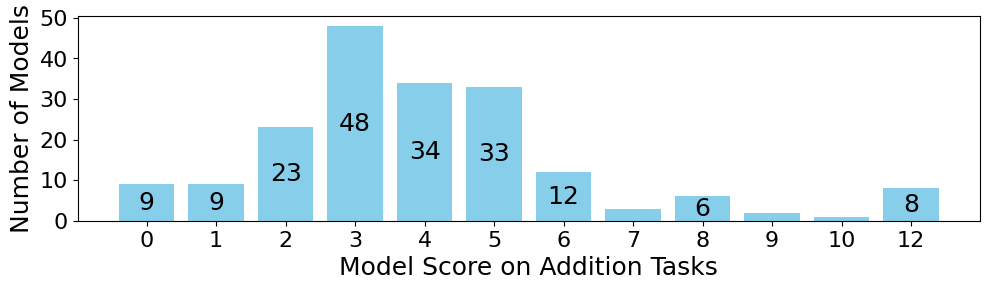

In [14]:
# Graph the results with categorical x-axis for scores (excluding negative scores)
scores_sorted = sorted([s for s in score_counts.keys() if isinstance(s, int) and s >= 0], key=lambda x: x)
counts_sorted = [score_counts[s] for s in scores_sorted]
plt.figure(figsize=(10,3))
bars = plt.bar(range(len(scores_sorted)), counts_sorted, color='skyblue')
plt.xlabel('Model Score on Addition Tasks', fontsize=18)
plt.ylabel('Number of Models', fontsize=18)
# No title per user request
plt.xticks(range(len(scores_sorted)), [str(s) for s in scores_sorted], fontsize=16)
plt.yticks(fontsize=16)
# Add count labels inside bars only where count > 4, with larger font
for bar, count in zip(bars, counts_sorted):
    if count > 4:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(count), ha='center', va='center', fontsize=18, color='black')
plt.tight_layout()
plt.show()

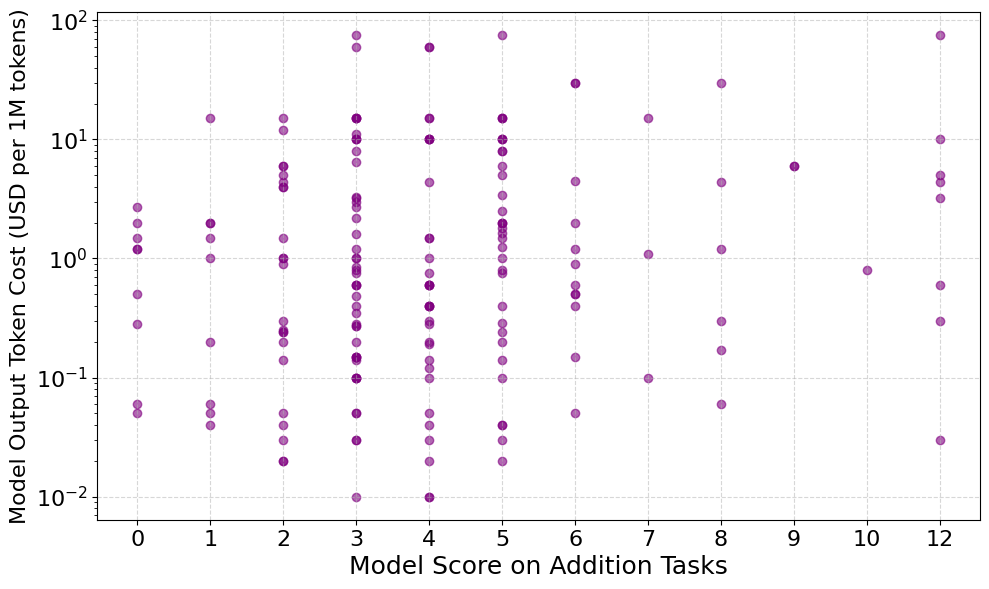

In [15]:
# Scatter plot: Output Token Cost vs. Model Score (Score as categorical x-axis, only non-negative scores)
import numpy as np
model_name_to_output_cost = {model[0]: model[2] for model in martian_models_data}
model_names = [entry['model'] for entry in model_scores]
scores = [entry['score'] for entry in model_scores]
output_costs = [model_name_to_output_cost.get(name, np.nan) for name in model_names]
# Filter for non-negative scores only
filtered = [(score, cost) for score, cost in zip(scores, output_costs) if isinstance(score, int) and score >= 0]
if filtered:
    filtered_scores, filtered_output_costs = zip(*filtered)
else:
    filtered_scores, filtered_output_costs = [], []
# Prepare categorical x-axis for scores
unique_scores = sorted(set(filtered_scores), key=lambda x: (isinstance(x, int), x))
score_to_x = {score: i for i, score in enumerate(unique_scores)}
x_vals = [score_to_x[score] for score in filtered_scores]
plt.figure(figsize=(10,6))
plt.scatter(x_vals, filtered_output_costs, alpha=0.6, color='purple')
plt.xlabel('Model Score on Addition Tasks', fontsize=18)
plt.ylabel('Model Output Token Cost (USD per 1M tokens)', fontsize=16)
# No title per user request
plt.xticks(range(len(unique_scores)), [str(s) for s in unique_scores], fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# List only models with a negative score or score 12
score_to_models = {}
for entry in model_scores:
    score = entry['score']
    if score <= 0 or score >= 10:
        score_to_models.setdefault(score, []).append(entry['model'])

for score in sorted(score_to_models):
    print(f"\nModels with score {score}:")
    for model in score_to_models[score]:
        print(f"  {model}")


Models with score -999:
  google/gemini-2.5-flash

Models with score -502:
  agentica-org/deepcoder-14b-preview
  arliai/qwq-32b-arliai-rpr-v1
  cognitivecomputations/dolphin-mixtral-8x22b
  cognitivecomputations/dolphin3.0-r1-mistral-24b
  infermatic/mn-inferor-12b
  moonshotai/kimi-vl-a3b-thinking
  nousresearch/deephermes-3-mistral-24b-preview
  nvidia/llama-3.3-nemotron-super-49b-v1
  perplexity/r1-1776
  pygmalionai/mythalion-13b
  shisa-ai/shisa-v2-llama3.3-70b
  sophosympatheia/midnight-rose-70b
  thudm/glm-4-32b
  thudm/glm-z1-32b

Models with score -400:
  ai21/jamba-1.6-mini
  ai21/jamba-1.6-large
  arcee-ai/arcee-blitz
  arcee-ai/caller-large
  deepseek/deepseek-r1-distill-qwen-1.5b
  deepseek/deepseek-r1-distill-qwen-7b
  eva-unit-01/eva-qwen-2.5-72b
  liquid/lfm-40b
  mistralai/mistral-7b-instruct-v0.2
  morph/morph-v2
  nothingiisreal/mn-celeste-12b
  nousresearch/nous-hermes-2-mixtral-8x7b-dpo
  openai/o1-preview
  openai/o1-preview-2024-09-12
  opengvlab/internvl3-14b


# Check zero-score model output

On occasion, check the output of the "0 score" models to see if unusual answer formats are hiding correct answers.
If so, is_ground_truth_correct should be updated

In [17]:
# Re-run models that scored 0 on test[0] and show their outputs
def run_zero_score_models():
    zero_score_models = [m['model'] for m in model_scores if m['score'] == 0]
    print(f"Re-running {len(zero_score_models)} models that scored 0 on the first test...")
    outputs = []
    for model_name in zero_score_models:
        try:
            answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
        except Exception as e:
            answer = f"Error: {str(e)}"
            success = False
        outputs.append({'model': model_name, 'output': answer, 'success': success})
        print(f"Model: {model_name}\nOutput: {answer}\nSuccess: {success}\n{'-'*40}")


#run_zero_score_models()

# Check -400 score models

Models can generate -400 scores if a mandatory parameter is missing. This may hide a model that can do addition.
Run the models that give a -400 score and see if the detailed error message shows the root cause.

In [24]:
# Re-run models that scored -400 and show their outputs and errors
def run_minus_400_score_models():
    minus_400_models = [m['model'] for m in model_scores if m['score'] == -400]
    print(f"Re-running {len(minus_400_models)} models that scored -400 on the first test...")
    outputs = []
    for model_name in minus_400_models:
        try:
            answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
        except Exception as e:
            answer = f"Error: {str(e)}"
            success = False
        outputs.append({'model': model_name, 'output': answer, 'success': success})
        print(f"Model: {model_name}\nOutput/Error: {answer}\nSuccess: {success}\n{'-'*40}")

#run_minus_400_score_models()

# High Variability Example
The model "alfredpros/codellama-7b-instruct-solidity" has high variability. Sometimes answer is correct

In [19]:
def run_high_variability_model():
    model_name = "alfredpros/codellama-7b-instruct-solidity"
    for i in range(5):
        answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
        print(f"Success: {success}. Output: {answer}")

#run_high_variability_model()

# Ask how the models that score >=10 work

Inconclusive: 

Sometimes the detailed methodology is mathematically incorrect.
Sometimes the outline methodology looks like a sentence from a text book.
The bext valid explanations say the model does addition like a human - line up digit pairs - then sum right digit-pair to-left digit pair calculating carries 
The "concise" setting makes these model reply immediately - unless they have many hidden "thinking tokens" the human approach is not feasible.

Some of these models gpt-4o-mini-search-preview and gpt-4o-search-preview explicitly say they have search/tool access. 
So they can just call a python function to calculate the sum.

In [20]:
def show_work_for_score_best_models():
    best_models = [m['model'] for m in model_scores if m['score'] >= 12]
    ground_prompt = "998522030597+1477969406="
    concise_prompt = f"Answer concisely: {ground_prompt}"
    explain_prompt = f"Show your work for {ground_prompt}"
    ground_truth = str(998522030597 + 1477969406)

    print(f"Querying {len(best_models)} models that scored best...")
    for model_name in best_models:
        try:
            answer, _ = run_model_inference(model_name, concise_prompt, ground_truth)
        except Exception as e:
            answer = f"Error: {str(e)}"
        print(f"Model: {model_name}\nOutput: {answer}\n{'-'*40}")

        try:
            answer, _ = run_model_inference(model_name, explain_prompt, ground_truth)
        except Exception as e:
            answer = f"Error: {str(e)}"
        print(f"Model: {model_name}\nOutput: {answer}\n{'-'*40}")

#show_work_for_score_best_models()

# Chat GPT 5
What did the Chat GPT 5 models score?

In [26]:
# Print scores for all models containing 'gpt-5'
for model, score in zip(model_names, model_scores):
    if 'gpt-5' in model:
        print(f"Model: {model}, Score: {score}")

Model: openai/gpt-5-mini, Score: {'model': 'openai/gpt-5-mini', 'score': 4}
Model: openai/gpt-5-nano, Score: {'model': 'openai/gpt-5-nano', 'score': 4}
Model: openai/gpt-5, Score: {'model': 'openai/gpt-5', 'score': 7}
